# Hedging
We will go through ad hedging exercise. Our objective is to define a portfolio to hedge a position of an option on an index. The index has a value of 10000, and we have written a
digital option on it. We will have to pay 10.000.000 euros if the index goes over 10.100 in one month. The volatility of the index is 20%. The risk free rate is 2.5%.
The contracts we can use are futures with leverage 100 and calls and puts, european, with the same expiry of out option and strikes any 250 points.

Lets start loading and defining things

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

In [2]:
def DigitalOptionPrice(Notional,S,K,r,T,sigma):
    Price=0
    if (S>K):
        Price=1
    if (T>0):
        d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
        d2=d1-sigma*T**0.5
        Price=np.exp(-r*T)*norm.cdf(d2)
    return Price*Notional

def Greeks(OptionPrice,Notional,S,K,r,T,sigma):
    P0=OptionPrice(Notional,S,K,r,T,sigma)
    Pu=OptionPrice(Notional,S+1,K,r,T,sigma)
    Pd=OptionPrice(Notional,S-1,K,r,T,sigma)
    delta=(Pu-Pd)/2
    gamma=Pu-2*P0+Pd
    return np.array([P0,delta,gamma])

def CallOptionPrice(Notional,S,K,r,T,sigma):
    Price=0
    if (S>K):
        Price=S-K
    if (T>0):
        d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
        d2=d1-sigma*T**0.5
        Price=S*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    return Price*Notional

def PutOptionPrice(Notional,S,K,r,T,sigma):
    Price=0
    if (S<K):
        Price=K-S
    if (T>0):
        d1=(np.log(S/K)+(r+sigma*sigma/2)*T)/(sigma*T**0.5)
        d2=d1-sigma*T**0.5
        Price=-S*norm.cdf(-d1)+np.exp(-r*T)*K*norm.cdf(-d2)
    return Price*Notional

def FuturePrice(Contracts,Leverage,S,K):
    return (S-K)*Leverage*Contracts

def FutureGreeks(Contracts,Leverage,S,K):
    return np.array([(S-K)*Leverage*Contracts,Leverage*Contracts,0])

Lets look at the final payoff of our option...

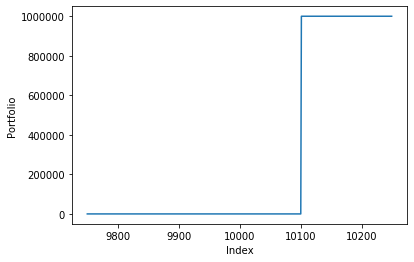

In [3]:
Index=[]
Ptf=[]
for i in range(500):
    CurrIndex=9750+i
    CurrPtf=DigitalOptionPrice(1000000,CurrIndex,10100,0.025,0,0.2)
    Index.append(CurrIndex)
    Ptf.append(CurrPtf)

plt.plot(Index,Ptf)
plt.xlabel('Index')
plt.ylabel('Portfolio')
plt.show()

But nowadays we are a month before, the reaction of our portfolio to index change is different...
First of all. What's the price of our option?

In [4]:
PDigital=DigitalOptionPrice(10000000,10000,10100,0.025,0.08333,0.2)
PDigital

4335161.764662938

What happens if the underlying price change?

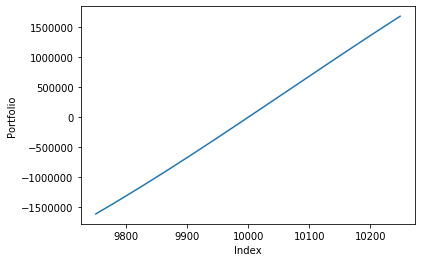

In [5]:
Index=[]
Ptf=[]
for i in range(500):
    CurrIndex=9750+i
    CurrPtf=DigitalOptionPrice(10000000,CurrIndex,10100,0.025,0.08333,0.2)-PDigital
    Index.append(CurrIndex)
    Ptf.append(CurrPtf)

plt.plot(Index,Ptf)
plt.xlabel('Index')
plt.ylabel('Portfolio')
plt.show()

Ok. Let's look to delta and gamma.

In [6]:
Greeks(DigitalOptionPrice,10000000,10000,10100,0.025,0.08333,0.2)

array([4.33516176e+06, 6.80225892e+03, 1.26536909e+00])

A first simple way to (almost) cancel delta is to use futures. We need 68 contracts short.

In [7]:
FutureGreeks(-68,100,10000,10000)

array([    0, -6800,     0])

Let's see what happens (mind the fact that Future price a time 0 is 0)...

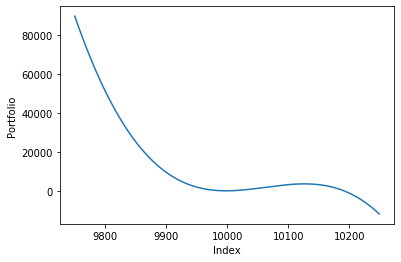

In [8]:
Index=[]
Ptf=[]
for i in range(500):
    CurrIndex=9750+i
    CurrPtf=DigitalOptionPrice(10000000,CurrIndex,10100,0.025,0.08333,0.2)+FuturePrice(-68,100,CurrIndex,10000)-PDigital
    Index.append(CurrIndex)
    Ptf.append(CurrPtf)

plt.plot(Index,Ptf)
plt.xlabel('Index')
plt.ylabel('Portfolio')
plt.show()

Well, is a fairly good result, and we have low delta. But we want zero delta...
Let's get near the current market condition.

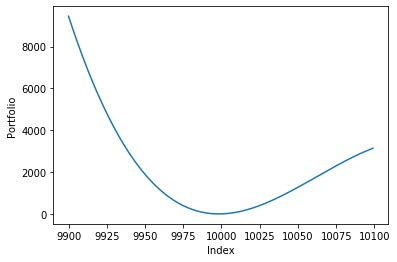

In [9]:
Index=[]
Ptf=[]
for i in range(200):
    CurrIndex=9900+i
    CurrPtf=DigitalOptionPrice(10000000,CurrIndex,10100,0.025,0.08333,0.2)+FuturePrice(-68,100,CurrIndex,10000)-PDigital
    Index.append(CurrIndex)
    Ptf.append(CurrPtf)

plt.plot(Index,Ptf)
plt.xlabel('Index')
plt.ylabel('Portfolio')
plt.show()

In [10]:
Greeks(DigitalOptionPrice,10000000,10000,10100,0.025,0.08333,0.2)+FutureGreeks(-68,100,CurrIndex,10000)

array([3.66196176e+06, 2.25892051e+00, 1.26536909e+00])

We will sell some out-of-money options to cancel small greeks.

In [11]:
Greeks(CallOptionPrice,1,10000,10500,0.025,0.08333,0.2)

array([6.99024958e+01, 2.17655306e-01, 5.09707028e-04])

In [12]:
Greeks(PutOptionPrice,1,10000,9500,0.025,0.08333,0.2)

array([ 5.39487850e+01, -1.70195293e-01,  4.38632779e-04])

We now have a linear problem...

In [13]:
M=np.matrix([[2.17655,-1.70195],[5.09707,4.38633]])
M

matrix([[ 2.17655, -1.70195],
        [ 5.09707,  4.38633]])

In [14]:
B=np.matrix([[22.589],[12654]])

In [15]:
np.linalg.solve(M,B)

matrix([[1187.33007384],
        [1505.15248522]])

This time we will get money the hedging!

In [16]:
HdgPrice=CallOptionPrice(-1187,10000,10500,0.025,0.08333,0.2)+PutOptionPrice(-1505,10000,9500,0.025,0.08333,0.2)
HdgPrice

-164167.1838738827

Let's look at what happens near the market point

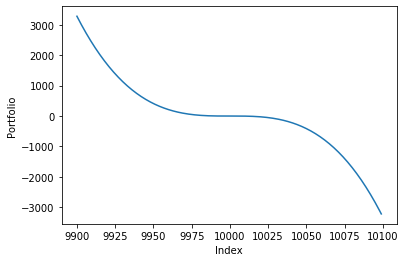

In [17]:
Index=[]
Ptf=[]
for i in range(200):
    CurrIndex=9900+i
    CurrPtf=DigitalOptionPrice(10000000,CurrIndex,10100,0.025,0.08333,0.2)+FuturePrice(-68,100,CurrIndex,10000)-PDigital+ \
    CallOptionPrice(-1187,CurrIndex,10500,0.025,0.08333,0.2)+PutOptionPrice(-1505,CurrIndex,9500,0.025,0.08333,0.2)-HdgPrice
    Index.append(CurrIndex)
    Ptf.append(CurrPtf)

plt.plot(Index,Ptf)
plt.xlabel('Index')
plt.ylabel('Portfolio')
plt.show()

We earned 164k eur and our greeks are canceled:

In [18]:
Greeks(DigitalOptionPrice,10000000,10000,10100,0.025,0.08333,0.2)+FutureGreeks(-68,100,10000,10000)+ \
Greeks(CallOptionPrice,-1187,10000,10500,0.025,0.08333,0.2)+Greeks(PutOptionPrice,-1505,10000,9500,0.025,0.08333,0.2)

array([4.17099458e+06, 4.59887162e-02, 2.04517244e-04])

Well... there is a problem... let's to the hedging payoff at a larger scale:

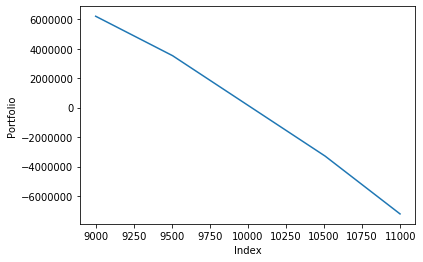

In [19]:
Index=[]
Ptf=[]
for i in range(2000):
    CurrIndex=9000+i
    CurrPtf=FuturePrice(-68,100,CurrIndex,10000)+CallOptionPrice(-1182,CurrIndex,10500,0.025,0.00,0.2)+PutOptionPrice(-1511,CurrIndex,9500,0.025,0.00,0.2)-HdgPrice
    Index.append(CurrIndex)
    Ptf.append(CurrPtf)

plt.plot(Index,Ptf)
plt.xlabel('Index')
plt.ylabel('Portfolio')
plt.show()

If the underlying price rises too much we could have a big problem, while before hedging we would have been happy... What do you think?